# Imports

In [35]:
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import ImageColor
import cv2
import math

import warnings
warnings.filterwarnings('ignore')

# Helper Functions

Taken from:

- **ISIC - Detect Skin Cancer - Let's Learn Together**  
  Very useful information and additional features  
  [Link to notebook](https://www.kaggle.com/code/dschettler8845/isic-detect-skin-cancer-let-s-learn-together/notebook)

In [36]:
import h5py

def load_img_from_hdf5(
    isic_id: str, 
    file_path: str = "./data/train-image.hdf5", 
    n_channels: int = 3
):
    """
    Load an image from the HDF5 dataset file by specifying an ISIC ID.
    
    The ISIC ID is expected to be in the form 'ISIC_#######'.
    
    Args:
        isic_id (str): The ID of the image to load.
        file_path (str): The path to the HDF5 file.
        n_channels (int): Number of channels (3 for RGB, 1 for grayscale).
    
    Returns:
        np.ndarray: The loaded image.
    
    Raises:
        KeyError: If the ISIC ID is not found in the HDF5 file.
        ValueError: If the image data cannot be decoded.
    
    Example Usage:
        img = load_img_from_hdf5('ISIC_0000000')
    """
    
    # Handle the case where the isic_id is passed incorrectly
    if not isic_id.lower().startswith("isic"):
        isic_id = f"ISIC_{int(str(isic_id).split('_', 1)[-1]):>07}"
        
    # Open the HDF5 file in read mode
    with h5py.File(file_path, 'r') as hf:
        
        # Retrieve the image data from the HDF5 dataset using the provided ISIC ID
        try:
            image_data = hf[isic_id][()]
        except KeyError:
            raise KeyError(f"ISIC ID {isic_id} not found in HDF5 file.")

        # Convert the binary data to a numpy array
        image_array = np.frombuffer(image_data, np.uint8)

        # Decode the image from the numpy array
        if n_channels == 3:
            # Load the image as a color image (BGR) and convert to RGB
            image = cv2.cvtColor(cv2.imdecode(image_array, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
        else:
            # Load the image as a grayscale image
            image = cv2.imdecode(image_array, cv2.IMREAD_GRAYSCALE)

        # If the image failed to load for some reason (problems decoding) ...
        if image is None:
            raise ValueError(f"Could not decode image for ISIC ID: {isic_id}")
        
        return image

In [37]:
# Create a Seaborn color palette
nb_palette = sns.color_palette(palette='tab20')

# Create colors for class labels
LABELS = ["Benign", "Malignant"]
COLORS = ['#66c2a5', '#fc8d62']
CLR_MAP_I2C = {i:c for i,c in enumerate(COLORS)}
CLR_MAP_S2C = {l:c for l,c in zip(LABELS, COLORS)}
LBL_MAP_I2S = {i:l for i,l in enumerate(LABELS)}
LBL_MAP_S2I = {v:k for k,v in LBL_MAP_I2S.items()}

def add_colored_border(img: np.ndarray, color: tuple[int] | str, border_width: int = 3) -> np.ndarray:
    """Add a colored border to an image.
    
    Args:
        img (np.ndarray): Input image as a numpy array.
        color (tuple[int] | str): Border color in RGB format OR a HEX string.
        border_width (int, optional): Width of the border in pixels.
    
    Returns:
        np.ndarray: Image with added border.
    """
    
    # Ensure color is RGB
    if isinstance(color, str) and color.startswith("#"):
        color = ImageColor.getcolor(color, "RGB")
        
    # Draw border
    bordered_img = cv2.copyMakeBorder(
        src=img, 
        top=border_width, 
        bottom=border_width, 
        left=border_width, 
        right=border_width, 
        borderType=cv2.BORDER_CONSTANT, 
        value=color
    )
    return bordered_img


def plot_patient_images(
    patient_isic_ids: list[str],
    labels: list[int] | None = None,
    patient_id: str | None = None,
    hdf5_file_path: str = "./data/train-image.hdf5",
    max_images: int = 60,
    images_per_row: int = 10,
    fig_width: int = 20,
):
    """Plot multiple images for a patient in a tiled layout with colored borders
    
    Args:
        patient_isic_ids (list[str]): 
            List of ISIC IDs for the patient's images.
        labels (list[int], optional): 
            The list of labels which will be used to color code malignant images.
                - Malignant images will be outlined with red (COLORS[1])
                - Benign images will be outlined with green (COLORS[0])
        patient_id (str, optional): 
            The patient id the isic_ids belong to.
        hdf5_file_path (str, optional): 
            The path to the HDF5 file.
        max_images (int, optional): 
            Maximum number of images to display.
        images_per_row (int, optional): 
            Number of images to display in each row.
        fig_width (int, optional): 
            The size of the figure width
    
    Returns:
        None; 
            plots the tiled images
    """
    # Limit the number of images to plot
    total_num_images = len(patient_isic_ids)
    patient_isic_ids = patient_isic_ids[:max_images]
    num_of_images_to_plot = len(patient_isic_ids)
    
    # Calculate the number of rows needed and figsize
    num_rows = math.ceil(num_of_images_to_plot / images_per_row)
    figsize = (fig_width, int(2.666*num_rows))
    
    # Create the figure
    fig = plt.figure(figsize=figsize)
    plt.suptitle(f"IMAGES FOR PATIENT: {patient_id}  (showing {num_of_images_to_plot} out of {total_num_images} images)", fontsize=16, fontweight="bold")
    
    # Process images in batches
    for i, isic_id in enumerate(patient_isic_ids):
        # Calculate the subplot position
        position = i + 1
        # Create a new subplot
        plt.subplot(num_rows, images_per_row, position)
        plt.title(f"{isic_id}{' - '+LBL_MAP_I2S[labels[i]] if labels is not None else ''}", fontsize=8 if labels is None else 7)
        
        # Load the image
        img = load_img_from_hdf5(isic_id, hdf5_file_path)
        
        # Add colored border
        if labels is not None:
            img = add_colored_border(img, COLORS[labels[i]])
        
        # Display the image
        plt.imshow(img)
        plt.axis('off')
    
    fig.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()

# Data Loading and Exploration

In [38]:
class ISIC2024_Preprocessing:
    
    def __init__(self):
        pass
    
    def filter_data(self, path):
        
        # Read dataset as polars DataFrame
        df = pl.read_csv(path, low_memory=True)
            
        # Drop redundant columns 
        for col in [
                    'image_type', # Only one unique value on train metadata
                    'tbp_lv_location_simple', # Similar information to 'tbp_lv_location'
                    'copyright_license', # Redundant information for lesion classification
                    
                    # Included only on train metadata
                    'lesion_id',
                    'iddx_full',
                    'iddx_1',
                    'iddx_2',
                    'iddx_3',
                    'iddx_4',
                    'iddx_5',
                    'mel_mitotic_index',
                    'mel_thick_mm',
                    'tbp_lv_dnn_lesion_confidence']:
            
            if col in df.columns:
                df = df.drop(col)            

        return df 
    
    def set_datatypes(self, df):
        
        # Handle NA values in age approximation column
        if ('age_approx' in df.columns) and df.select(pl.col('age_approx').str.contains('NA').any()).item():
            
            # Replace the value with -1
            df = df.with_columns(pl.when(pl.col('age_approx') == 'NA').then(-1).otherwise(pl.col('age_approx'))
                   .alias('age_approx'))
            
        # Define numeric columns (int)
        for col in ['target',
                    'age_approx',
                    'tbp_lv_symm_2axis_angle']:
            
            # Set dtype for numeric columns (int)
            if col in df.columns:
                df = df.with_columns(pl.col(col).cast(pl.Int16))
                        
        # Define numeric columns (float)
        for col in ['clin_size_long_diam_mm', 
                    'tbp_lv_A', 
                    'tbp_lv_Aext', 
                    'tbp_lv_B', 
                    'tbp_lv_Bext', 
                    'tbp_lv_C', 
                    'tbp_lv_Cext',
                    'tbp_lv_H', 
                    'tbp_lv_Hext',
                    'tbp_lv_L', 
                    'tbp_lv_Lext',
                    'tbp_lv_areaMM2', 
                    'tbp_lv_area_perim_ratio',
                    'tbp_lv_color_std_mean',
                    'tbp_lv_deltaA', 
                    'tbp_lv_deltaB',
                    'tbp_lv_deltaL', 
                    'tbp_lv_deltaLB',
                    'tbp_lv_deltaLBnorm',
                    'tbp_lv_eccentricity', 
                    'tbp_lv_minorAxisMM',
                    'tbp_lv_nevi_confidence',
                    'tbp_lv_norm_border',
                    'tbp_lv_norm_color',
                    'tbp_lv_perimeterMM',
                    'tbp_lv_radial_color_std_max',
                    'tbp_lv_stdL',
                    'tbp_lv_stdLExt',
                    'tbp_lv_symm_2axis',
                    'tbp_lv_x',
                    'tbp_lv_y',
                    'tbp_lv_z']: 
            
            # Set dtype for numeric columns (float)
            if col in df.columns:
                df = df.with_columns(pl.col(col).cast(pl.Float32))
                
        # Define categorical columns
        for col in ['sex', 
                    'anatom_site_general', 
                    'tbp_tile_type', 
                    'tbp_lv_location',
                    'attribution']:
            
            # Set dtype for categorical columns
            if col in df.columns:
                df = df.with_columns(pl.col(col).cast(pl.Categorical))
                                            
        return df
    
    def initial_preprocessing(self, df):
        
        # Filter data
        df = self.filter_data(df)
        
        # Set datatypes
        df = self.set_datatypes(df)
        
        return df.to_pandas()

In [39]:
pp = ISIC2024_Preprocessing()
df_train = pp.initial_preprocessing('./data/train-metadata.csv')
df_test = pp.initial_preprocessing('./data/test-metadata.csv')

In [40]:
# Columns NOT in test
diff_cols = list(set(df_train.columns) - set(df_test.columns))
print(diff_cols)

['target']


In [41]:
df_train['target'].value_counts()

target
0    400666
1       393
Name: count, dtype: int64

In [42]:
# Which is the patient with more positive samples?
df_train[df_train.target==1].groupby("patient_id")["target"].count().idxmax()

'IP_2456971'

In [43]:
# Even for the patient with more positive samples the ratio is high (30:1)
print(df_train[df_train['patient_id'] == 'IP_2456971']['target'].value_counts(), '\n')
print(f'Patient IP_2456971 ratio of neg to pos samples: {431/14}:1')

target
0    431
1     14
Name: count, dtype: int64 

Patient IP_2456971 ratio of neg to pos samples: 30.785714285714285:1


In [44]:
#Ratio for the whole training set
RATIO = df_train.target.value_counts()[0] / df_train.target.value_counts()[1]
print(f'TOTAL ratio of neg to pos samples: {RATIO}:1')

TOTAL ratio of neg to pos samples: 1019.5063613231553:1


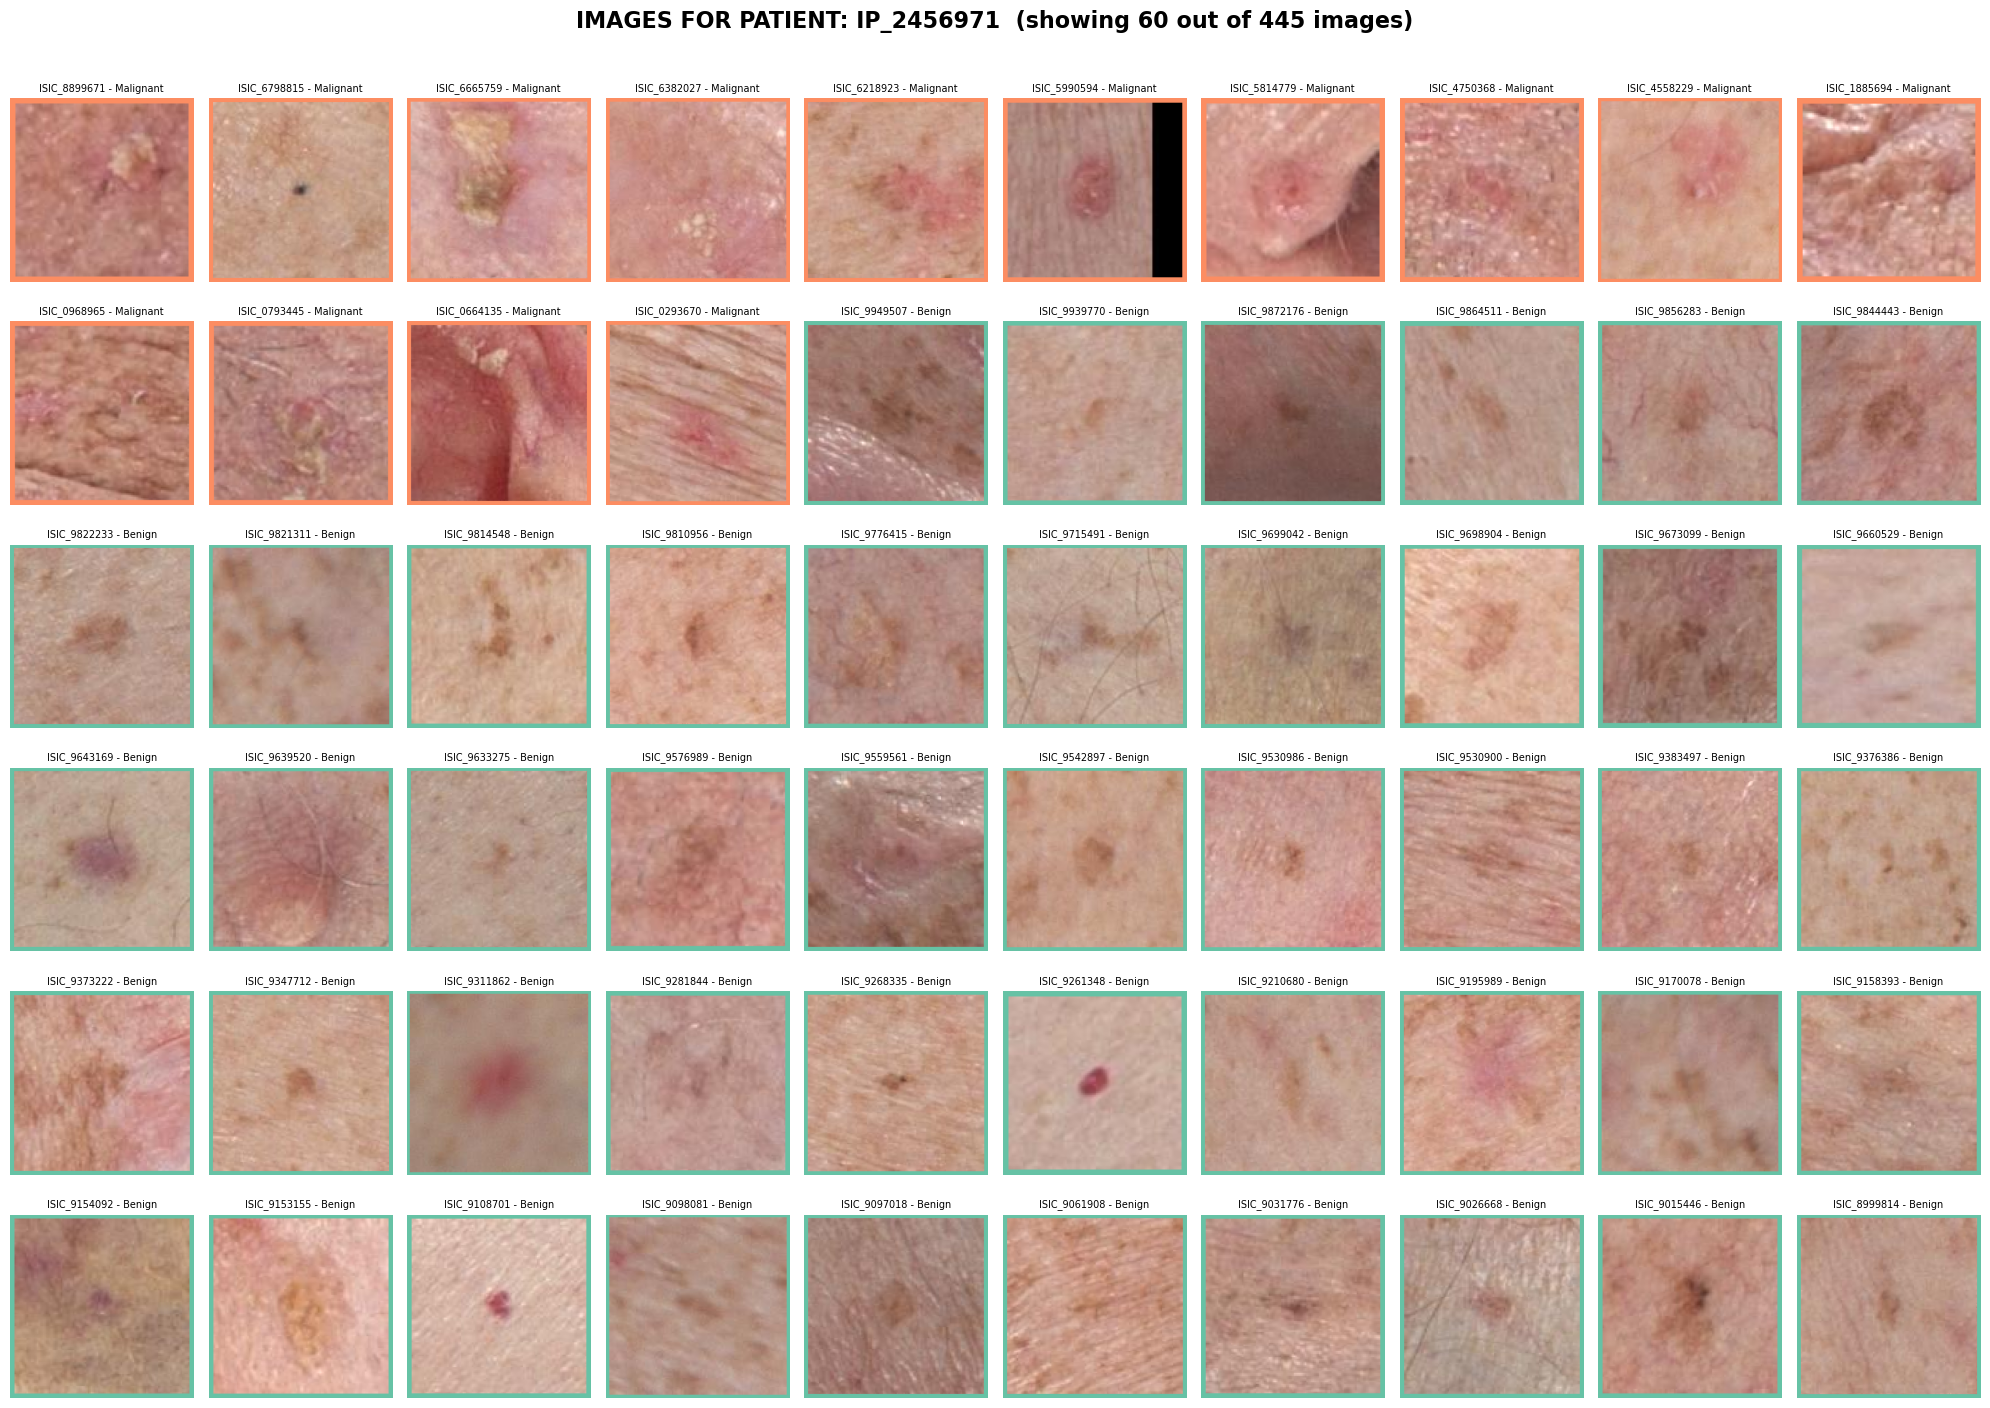

In [45]:
DEMO_PATIENT_DF = df_train[df_train.patient_id=='IP_2456971'].sort_values(by=["target", "isic_id"], ascending=False).reset_index(drop=True)

plot_patient_images(
    patient_isic_ids=DEMO_PATIENT_DF.isic_id.to_list(),
    labels=DEMO_PATIENT_DF.target.to_list(),
    patient_id=DEMO_PATIENT_DF.patient_id[0]
)

## Target distribution

In [46]:
def extract_columns(df):
    """
    Extracts categorical and numerical columns from a DataFrame.

    Parameters:
    df (pd.DataFrame): The input DataFrame.

    Returns:
    tuple: A tuple containing two lists - categorical columns and numerical columns.
    """
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
    
    return categorical_cols, numerical_cols

def plot_categorical_target_distribution(df, target_col, categorical_cols):
    """
    Plots the distribution of the target variable for each categorical column.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    target_col (str): The name of the target column.
    categorical_cols (list): List of categorical columns to plot.
    """
    for col in categorical_cols:
        plt.figure(figsize=(8, 4))
        sns.countplot(data=df, x=col, hue=target_col)
        plt.title(f'Distribution of {target_col} in {col}')
        plt.xticks(rotation=45)
        plt.show()
        
def plot_numerical_target_distribution(df, target_col, numerical_cols):
    """
    Plots the distribution of the target variable for each numerical column as KDE plots.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    target_col (str): The name of the target column.
    numerical_cols (list): List of numerical columns to plot.
    """
    for col in numerical_cols:
        plt.figure(figsize=(8, 4))
        sns.kdeplot(data=df, x=col, hue=target_col, fill=True)
        plt.title(f'Distribution of {col} by {target_col}')
        plt.show()

In [1]:
categorical_cols, numerical_cols = extract_columns(df_train)
print(categorical_cols)
print(numerical_cols)

NameError: name 'extract_columns' is not defined

In [47]:
categorical_cols, numerical_cols = extract_columns(df_train)

# Plot categorical distributions
plot_categorical_target_distribution(df_train, 'target', categorical_cols)

# Plot numerical distributions
plot_numerical_target_distribution(df_train, 'target', numerical_cols)

: 

: 